In [12]:
import pandas as pd
df = pd.read_csv('all-data.csv', encoding='ISO-8859-1', header=None)
df.columns = ['Sentiment', 'Review']
df.head()

,Sentiment,Review
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [13]:
label_map = {'positive': 1, 'negative': 0, 'neutral': 2}
df['Label'] = df['Sentiment'].map(label_map)
df['Label'].value_counts()

,count
Label,
2,2879
1,1363
0,604


In [14]:
df

,Sentiment,Review,Label
0,neutral,"According to Gran , the company has no plans t...",2
1,neutral,Technopolis plans to develop in stages an area...,2
2,negative,The international electronic industry company ...,0
3,positive,With the new production plant the company woul...,1
4,positive,According to the company 's updated strategy f...,1
...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,0
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,2
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,0
4844,negative,Net sales of the Paper segment decreased to EU...,0


Class Counts:
 Label
2    2879
1    1363
0     604
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


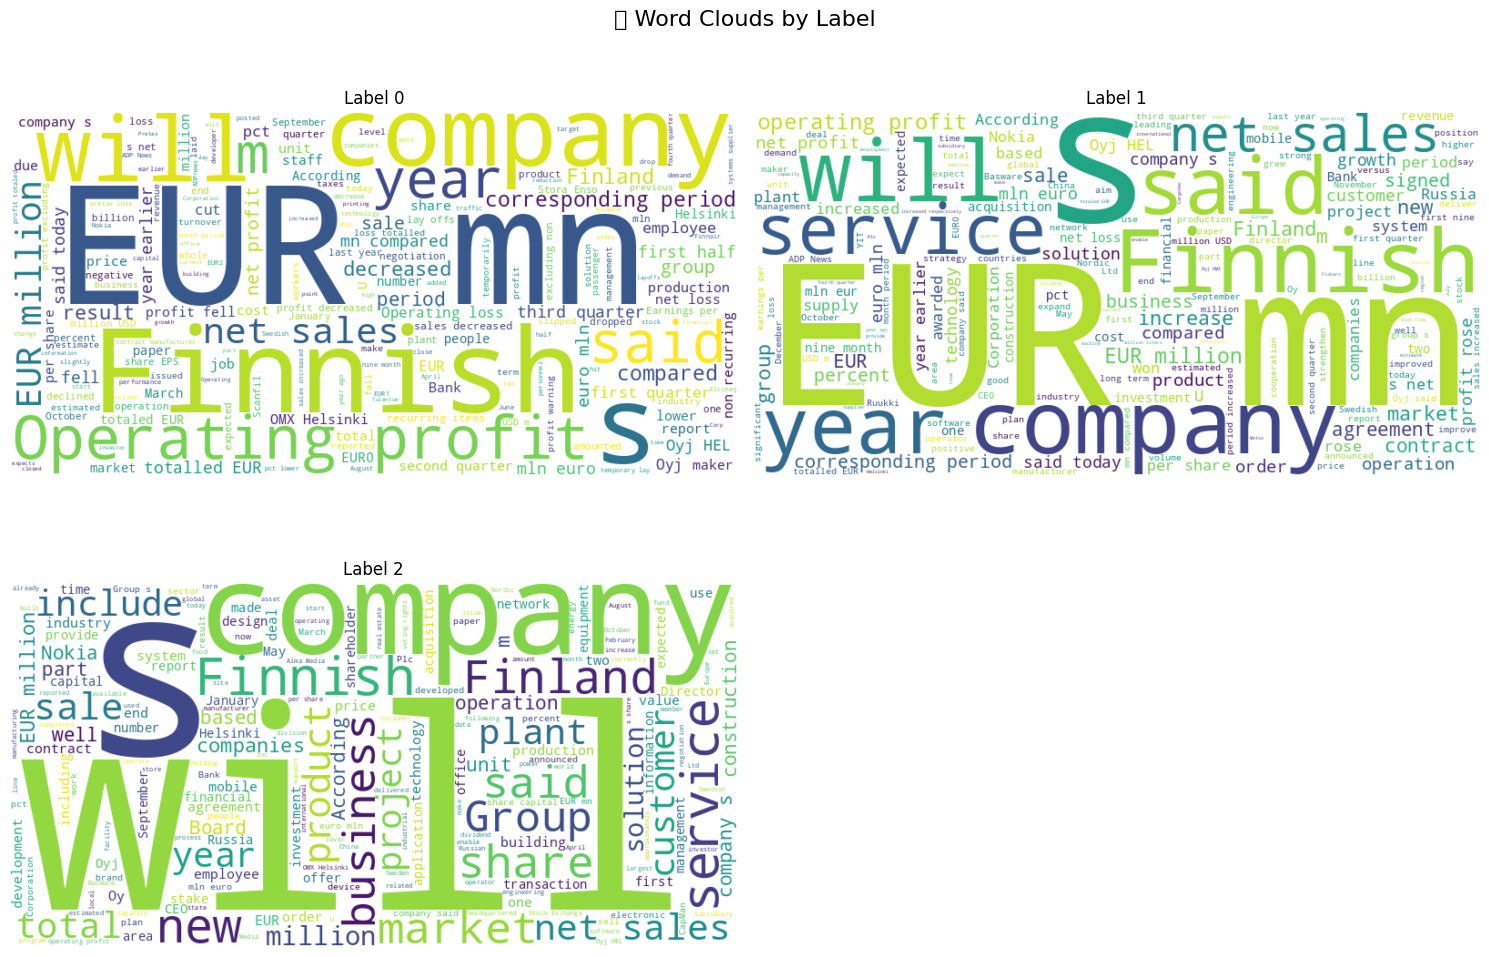

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Ensure Review column is string
df['Review'] = df['Review'].astype(str)

# Word count
df['word_count'] = df['Review'].str.split().str.len()

# Class counts
class_counts = df['Label'].value_counts()
print("Class Counts:\n", class_counts)

# Plot Word Clouds per Label
labels = df['Label'].unique()
labels.sort()  # optional: sort for order

plt.figure(figsize=(15, 10))

for i, label in enumerate(labels):
    text = " ".join(df[df['Label'] == label]['Review'])

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.subplot(2, (len(labels) + 1) // 2, i + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Label {label}")

plt.tight_layout()
plt.suptitle("🌀 Word Clouds by Label", fontsize=16, y=1.02)
plt.show()


In [16]:
pip install nltk scikit-learn wordcloud


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


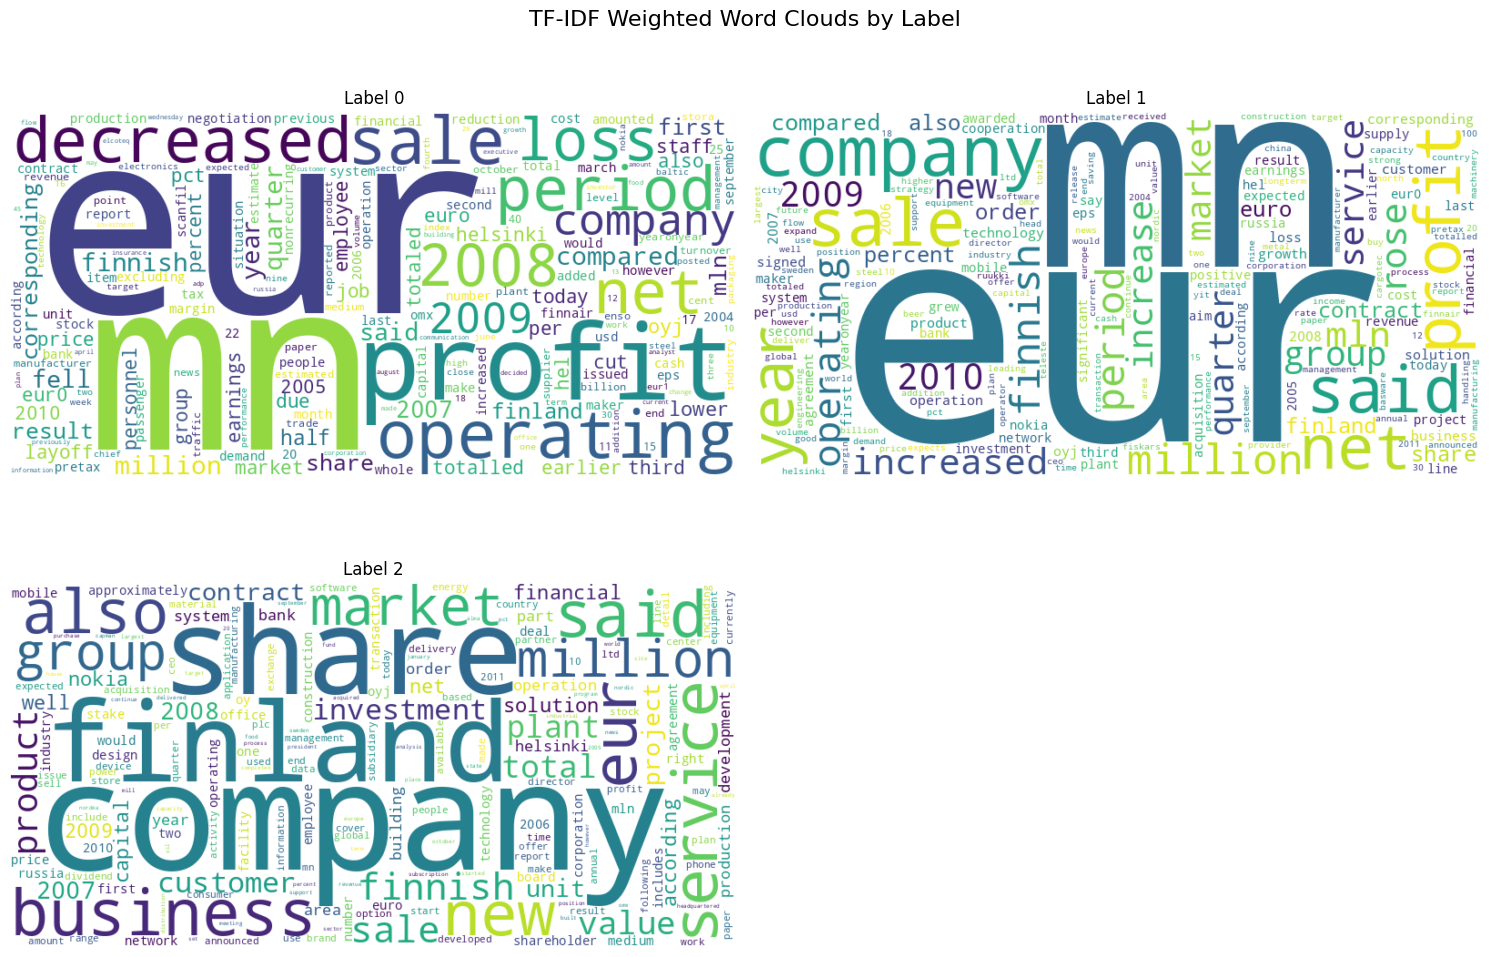

In [17]:
import pandas as pd
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Download NLTK resources
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Load data
# Assuming your DataFrame is named df and columns are: ['Id', 'Review', 'Label']
df['Review'] = df['Review'].astype(str)

# Step 1: Clean text
def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stopwords.words('english')]  # Remove stopwords
    return tokens

# Step 2: Lemmatize
lemmatizer = WordNetLemmatizer()
def lemmatize(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

# Step 3: Combine all processing steps
def preprocess(text):
    tokens = clean_text(text)
    lemmas = lemmatize(tokens)
    return ' '.join(lemmas)

df['Processed_Review'] = df['Review'].apply(preprocess)

# Step 4: TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=500)  # Use top 500 words
tfidf_matrix = vectorizer.fit_transform(df['Processed_Review'])

# Feature names
feature_names = vectorizer.get_feature_names_out()

# Optional: Create word clouds per Label from TF-IDF
labels = sorted(df['Label'].unique())
plt.figure(figsize=(15, 10))

for i, label in enumerate(labels):
    subset = df[df['Label'] == label]
    tfidf_sub = vectorizer.transform(subset['Processed_Review'])
    avg_tfidf = tfidf_sub.mean(axis=0).A1  # Average tf-idf per word
    tfidf_dict = {word: avg_tfidf[idx] for idx, word in enumerate(feature_names)}

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_dict)

    plt.subplot(2, (len(labels) + 1) // 2, i + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Label {label}")

plt.tight_layout()
plt.suptitle("TF-IDF Weighted Word Clouds by Label", fontsize=16, y=1.02)
plt.show()


Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.36      0.46       121
           1       0.61      0.35      0.44       273
           2       0.70      0.91      0.79       576

    accuracy                           0.68       970
   macro avg       0.65      0.54      0.57       970
weighted avg       0.67      0.68      0.65       970



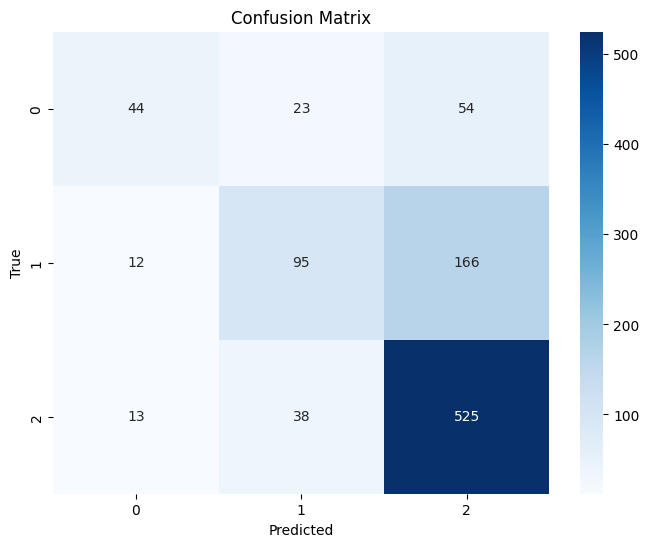

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Labels
y = df['Label']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, y, test_size=0.2, random_state=42, stratify=y)

# Train Naive Bayes
model = MultinomialNB()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Classification Report:

              precision    recall  f1-score   support

           0       0.55      0.60      0.57       121
           1       0.61      0.54      0.57       273
           2       0.77      0.80      0.79       576

    accuracy                           0.70       970
   macro avg       0.65      0.65      0.65       970
weighted avg       0.70      0.70      0.70       970



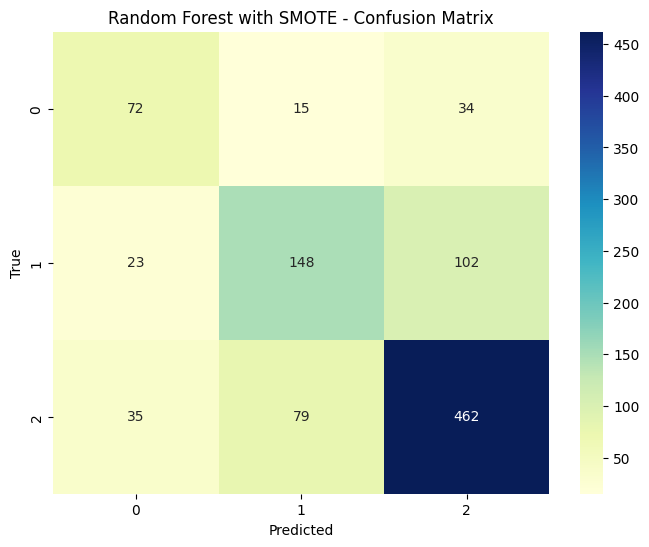

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# Labels
y = df['Label']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict on test data
y_pred = rf_model.predict(X_test)

# Evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Random Forest with SMOTE - Confusion Matrix")
plt.show()


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


55/55 ━━━━━━━━━━━━━━━━━━━━ 74s 926ms/step - accuracy: 0.5526 - loss: 0.9808 - val_accuracy: 0.6443 - val_loss: 0.8326
Epoch 2/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 69s 706ms/step - accuracy: 0.6910 - loss: 0.7375 - val_accuracy: 0.6727 - val_loss: 0.7765
Epoch 3/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 38s 649ms/step - accuracy: 0.7894 - loss: 0.5459 - val_accuracy: 0.6624 - val_loss: 0.8314
Epoch 4/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 41s 637ms/step - accuracy: 0.8560 - loss: 0.3467 - val_accuracy: 0.6804 - val_loss: 0.8757
Epoch 5/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 39s 613ms/step - accuracy: 0.9295 - loss: 0.2172 - val_accuracy: 0.6985 - val_loss: 0.9766
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.59      0.55      0.57       121
           1       0.64      0.60      0.62       273
           2       0.78      0.81      0.80       576

    accuracy                           0.72       970
   macro avg       0.67      0.66

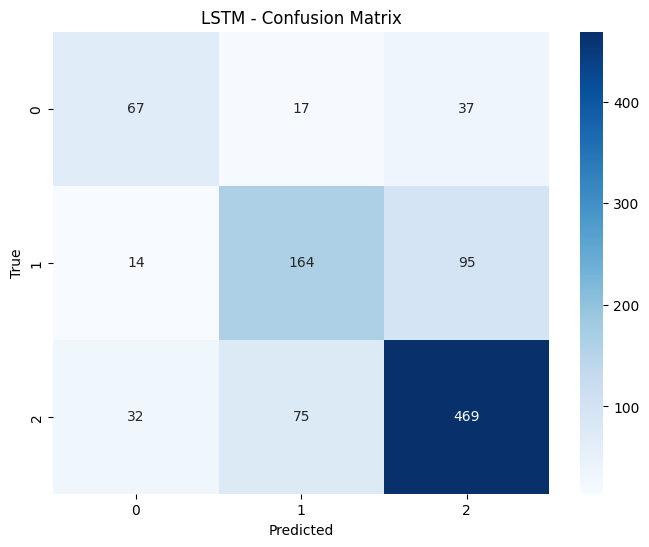

In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Prepare the text and labels
texts = df['Review'].astype(str).values
labels = df['Label'].values

# Step 2: Tokenize the text
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=200)

# Step 3: Encode the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels_categorical, test_size=0.2, stratify=labels_encoded, random_state=42)

# Step 5: Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=200))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Step 6: Compile and train the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

# Step 7: Evaluate
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_.astype(str)))

# Step 8: Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("LSTM - Confusion Matrix")
plt.show()


In [21]:
# Sample new input
new_text = ["The market remained unchanged during mid-day trading"]

# 1. Tokenize and pad the new input
new_seq = tokenizer.texts_to_sequences(new_text)
new_pad = pad_sequences(new_seq, maxlen=200)

# 2. Predict
pred_probs = model.predict(new_pad)
pred_label_index = np.argmax(pred_probs, axis=1)[0]
predicted_sentiment = label_encoder.inverse_transform([pred_label_index])[0]

# 3. Output
print("Predicted Sentiment:", predicted_sentiment)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Predicted Sentiment: 2


In [22]:
model.save('sentiment_model.h5')



In [23]:
# Save tokenizer and label encoder
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
